In [9]:
import os
import numpy as np
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Conv2d, Parameter, Softmax
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
from PIL import Image, ImageFilter
import albumentations as A
from albumentations.pytorch import ToTensorV2

import datetime
from tqdm import tqdm

# Data loading and augmentation

In [10]:
data_path = "/kaggle/input/dataml2/data/training"
train_path = data_path + "/images"
label_path  = data_path + "/groundtruth"

image_path_list = os.listdir(train_path)
image_path = os.path.join(train_path, image_path_list[0])
label_pt = os.path.join(label_path, image_path_list[0])

image = Image.open(image_path)
label = Image.open(label_pt)

image_array = np.array(image)
label_array = np.array(label)

class RoadSegmentationDataset(Dataset):
    def __init__(self, data_dir, image_folder='images', mask_folder='groundtruth', transform=None, transform_x=None):
        """
        Args:
            data_dir (str): Root directory of the dataset.
            image_folder (str): Name of the folder containing road images.
            mask_folder (str): Name of the folder containing segmentation masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.image_folder = os.path.join(data_dir, image_folder)
        self.mask_folder = os.path.join(data_dir, mask_folder)
        self.transform = transform
        self.transform_x = transform_x

        assert os.path.exists(self.image_folder), f"Image folder '{self.image_folder}' not found."
        assert os.path.exists(self.mask_folder), f"Mask folder '{self.mask_folder}' not found."

        self.image_list = sorted(os.listdir(self.image_folder))
        self.mask_list = sorted(os.listdir(self.mask_folder))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        mask_name = self.image_list[idx]

        img_path = os.path.join(self.image_folder, img_name)
        mask_path = os.path.join(self.mask_folder, mask_name)

        image = np.array(Image.open(img_path).convert("RGB")).astype(np.float32)  # Adjust as needed
        mask = np.array(Image.open(mask_path).convert("L")).astype(np.float32)    # Assuming grayscale mask, adjust as needed
        mask = mask/np.max(mask)

        if self.transform_x:
             image = self.transform_x(image)

        if self.transform:
            augmentations=self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        mask=mask.unsqueeze(0)
        return (image,mask)

In [11]:
trans=A.Compose(
        [A.Rotate(limit=70, p=1.0),
         A.VerticalFlip(p=0.1),
         A.HorizontalFlip(p=0.5),
         A.RandomSizedCrop(min_max_height=(200,200), height = 400, width = 400, p=0.1),
         A.RandomBrightnessContrast(p=0.2),
         ToTensorV2()
        ])

transform_x = standardize
trans_non_augmented = ToTensorV2()

# UNET

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1 ,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.final_layer = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = self.final_layer(logits)
        return logits

    def use_checkpointing(self,):
        self.inc = torch.utils.checkpoint.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint.checkpoint(self.outc)

# ResU-NET

In [13]:

class ResUNET(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False, pretrained_backbone=True):
        super(ResUNET, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.backbone = models.resnet34(pretrained=pretrained_backbone)
        self.inc = nn.Sequential(
        self.backbone.conv1,
        self.backbone.bn1,
        self.backbone.relu,
        self.backbone.maxpool,
        )

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.final_layer = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits=self.final_layer(logits)
        return logits

    def use_checkpointing(self,):
        self.inc = torch.utils.checkpoint.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint.checkpoint(self.outc)

# MARESUNET

In [14]:
nonlinearity = partial(F.relu, inplace=True)

def conv3otherRelu(in_planes, out_planes, kernel_size=None, stride=None, padding=None):
    # 3x3 convolution with padding and relu
    if kernel_size is None:
        kernel_size = 3
    assert isinstance(kernel_size, (int, tuple)), 'kernel_size is not in (int, tuple)!'

    if stride is None:
        stride = 1
    assert isinstance(stride, (int, tuple)), 'stride is not in (int, tuple)!'

    if padding is None:
        padding = 1
    assert isinstance(padding, (int, tuple)), 'padding is not in (int, tuple)!'

    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
        nn.ReLU(inplace=True)  # inplace=True
    )


def l2_norm(x):
    return torch.einsum("bcn, bn->bcn", x, 1 / torch.norm(x, p=2, dim=-2))


class PAM_Module(Module):
    def __init__(self, in_places, scale=8, eps=1e-6):
        super(PAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.in_places = in_places
        self.l2_norm = l2_norm
        self.eps = eps

        self.query_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_places, out_channels=in_places, kernel_size=1)

    def forward(self, x):
        # Apply the feature map to the queries and keys
        batch_size, chnnels, width, height = x.shape
        Q = self.query_conv(x).view(batch_size, -1, width * height)
        K = self.key_conv(x).view(batch_size, -1, width * height)
        V = self.value_conv(x).view(batch_size, -1, width * height)

        Q = self.l2_norm(Q).permute(-3, -1, -2)
        K = self.l2_norm(K)

        tailor_sum = 1 / (width * height + torch.einsum("bnc, bc->bn", Q, torch.sum(K, dim=-1) + self.eps))
        value_sum = torch.einsum("bcn->bc", V).unsqueeze(-1)
        value_sum = value_sum.expand(-1, chnnels, width * height)

        matrix = torch.einsum('bmn, bcn->bmc', K, V)
        matrix_sum = value_sum + torch.einsum("bnm, bmc->bcn", Q, matrix)

        weight_value = torch.einsum("bcn, bn->bcn", matrix_sum, tailor_sum)
        weight_value = weight_value.view(batch_size, chnnels, height, width)

        return (x + self.gamma * weight_value).contiguous()


class CAM_Module(Module):
    def __init__(self):
        super(CAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        batch_size, chnnels, width, height = x.shape
        proj_query = x.view(batch_size, chnnels, -1)
        proj_key = x.view(batch_size, chnnels, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy_new)
        proj_value = x.view(batch_size, chnnels, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(batch_size, chnnels, height, width)

        out = self.gamma * out + x
        return out


class PAM_CAM_Layer(nn.Module):
    def __init__(self, in_ch):
        super(PAM_CAM_Layer, self).__init__()
        self.conv1 = conv3otherRelu(in_ch, in_ch)

        self.PAM = PAM_Module(in_ch)
        self.CAM = CAM_Module()

        self.conv2P = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))
        self.conv2C = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))

        self.conv3 = nn.Sequential(nn.Dropout2d(0.1, False), conv3otherRelu(in_ch, in_ch, 1, 1, 0))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2P(self.PAM(x)) + self.conv2C(self.CAM(x))
        return self.conv3(x)


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 3, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 3)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 3, in_channels // 3, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 3)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 3, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class MAResUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=1):
        super(MAResUNet, self).__init__()
        self.name = 'MAResUNet'

        filters = [64, 128, 256, 512]
        resnet = models.resnet34(pretrained=True)

        #adjustment
        weight = resnet.conv1.weight.clone()
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
          resnet.conv1.weight[:, :3] = weight
          resnet.conv1.weight[:, 2] = resnet.conv1.weight[:, 0]

        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        
        # What we changed from the paper is one layer less, see original code on : https://github.com/lironui/MAResU-Net/blob/main/MAResUNet.py 
        
        self.attention3 = PAM_CAM_Layer(filters[2])
        self.attention2 = PAM_CAM_Layer(filters[1])
        self.attention1 = PAM_CAM_Layer(filters[0])

        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)
        self.final_layer = nn.Sigmoid()

    def forward(self, x):
        # First layer
        x1 = self.firstconv(x)
        x1 = self.firstmaxpool(x1)
        
        # Encoding 
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e3 = self.attention3(e3)
        
        # Decoding
        d3 = self.decoder3(e3) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Last layers
        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)
        
        logits=self.final_layer(out)

        return logits

# Metrics computation

In [15]:
def compute_metrics(target, predicted_probs, threshold=0.5):

    predicted_binary = (predicted_probs > threshold).float()

    target_flat = target.view(-1)
    predicted_flat = predicted_binary.view(-1)

    correct_predictions = (target_flat == predicted_flat).float()
    accuracy = correct_predictions.mean().item()
    
    return np.round(accuracy,3)

def compute_f1_score(target_masks, predicted_masks, threshold=0.5):
    predicted_masks = (predicted_masks > threshold).float()

    target_flat = target_masks.view(-1)
    predicted_flat = predicted_masks.view(-1)

    tp = torch.sum(target_flat * predicted_flat)
    fp = torch.sum((1 - target_flat) * predicted_flat)
    fn = torch.sum(target_flat * (1 - predicted_flat))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1_score.item()

# Training functions

In [16]:
def get_dataloaders(batch_size, show_examples=False):
    
    dataset_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans, transform_x=transform_x)
    dataset_non_augmented = RoadSegmentationDataset(data_dir=data_path, transform=trans_non_augmented, transform_x=transform_x)
    dataset = ConcatDataset([dataset_augmented, dataset_non_augmented])

    val_percent=0.15
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))



    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    if show_examples:
      for batch in train_loader:
          images = batch[0]
          masks = batch[1]

          # Images and masks are 4D tensors (batch_size, channels, height, width)
          image = images[0]
          mask = masks[0]
          image_np = image.numpy()
          mask_np = mask.squeeze().numpy()  # Assuming mask is single-channel

          plt.figure(figsize=(8, 4))
        
          plt.subplot(1, 2, 1)
          plt.imshow(np.transpose(image_np, (1, 2, 0)))
          plt.title('Image')
          plt.axis('off')

          plt.subplot(1, 2, 2)
          plt.imshow(mask_np, cmap='gray')
          plt.title('Mask')
          plt.axis('off')

          plt.show()

          # Break after the first batch
          break
    return train_loader, val_loader

In [17]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    f1_score_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_float = loss.item()
        f1_float = compute_f1_score(target, output, 0.5)
        accuracy_float = compute_metrics(target, output, 0.5)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        f1_score_history.append(f1_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"batch_f1={f1_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history , f1_score_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = (output>0.5)
        correct += compute_metrics(target, pred)
        f1 = compute_f1_score(target, pred)

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(test_loss, correct, len(val_loader.dataset), 100.0 * correct / len(val_loader.dataset))
    )
    return test_loss, correct , f1



@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output
        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points

In [18]:
def run_training(
    model_factory,
    num_epochs,
    data_kwargs,
    optimizer_kwargs,
    device="cuda",
):
    # Data Loading
    train_loader, val_loader = get_dataloaders(**data_kwargs)
    model = model_factory
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.binary_cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max = (len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    lr_history = []
    train_loss_history = []
    train_acc_history = []
    train_f1_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        train_loss, train_acc, lrs, f1_score = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
        
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        train_f1_history.extend(f1_score)
        lr_history.extend(lrs)

        val_loss, val_acc, f1_val = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_f1_history.append(f1_val)

    # Plot training curves
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)
    
    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 1)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    points = get_predictions(model, device, val_loader, partial(torch.nn.functional.cross_entropy, reduction="none"))

    for i, (data, loss, pred, target) in enumerate(points[:5]):
        plt.figure(figsize=(12, 4))
        mask_pred=(pred>0.5)

        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(np.squeeze(data, axis=0), (1,2,0)), cmap='gray')
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(np.squeeze(mask_pred, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)
        plt.title('Predicted Label')

        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(np.squeeze(target, axis=0), (1,2,0)), cmap='viridis', vmin=0, vmax=1)
        plt.title('Ground Truth Label')

        plt.show()

    return val_acc

# Training loop

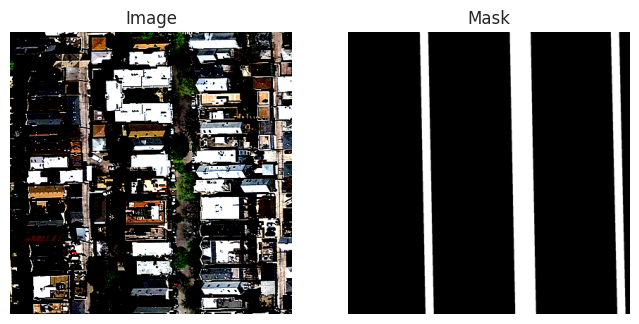

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1-000 batch_loss=7.06e-01 batch_acc=0.243 batch_f1=0.324 lr=5.000e-04 
Train Epoch: 1-002 batch_loss=6.59e-01 batch_acc=0.795 batch_f1=0.009 lr=4.998e-04 
Train Epoch: 1-004 batch_loss=6.17e-01 batch_acc=0.771 batch_f1=0.000 lr=4.993e-04 
Train Epoch: 1-006 batch_loss=5.55e-01 batch_acc=0.790 batch_f1=0.000 lr=4.987e-04 
Train Epoch: 1-008 batch_loss=5.20e-01 batch_acc=0.749 batch_f1=0.000 lr=4.978e-04 
Train Epoch: 1-010 batch_loss=4.77e-01 batch_acc=0.760 batch_f1=0.000 lr=4.967e-04 
Train Epoch: 1-012 batch_loss=4.90e-01 batch_acc=0.742 batch_f1=0.000 lr=4.954e-04 
Train Epoch: 1-014 batch_loss=4.48e-01 batch_acc=0.770 batch_f1=0.000 lr=4.938e-04 
Train Epoch: 1-016 batch_loss=3.92e-01 batch_acc=0.803 batch_f1=0.000 lr=4.921e-04 
Train Epoch: 1-018 batch_loss=4.60e-01 batch_acc=0.746 batch_f1=0.000 lr=4.902e-04 
Train Epoch: 1-020 batch_loss=3.92e-01 batch_acc=0.789 batch_f1=0.000 lr=4.880e-04 


Epochs:  10%|█         | 1/10 [00:05<00:53,  5.92s/it]

Test set: Average loss: 0.4891, Accuracy: 3.035/30 (10%)
Train Epoch: 2-000 batch_loss=4.14e-01 batch_acc=0.753 batch_f1=0.000 lr=4.856e-04 
Train Epoch: 2-002 batch_loss=3.72e-01 batch_acc=0.777 batch_f1=0.000 lr=4.830e-04 
Train Epoch: 2-004 batch_loss=3.60e-01 batch_acc=0.787 batch_f1=0.000 lr=4.803e-04 
Train Epoch: 2-006 batch_loss=3.61e-01 batch_acc=0.762 batch_f1=0.000 lr=4.773e-04 
Train Epoch: 2-008 batch_loss=3.04e-01 batch_acc=0.831 batch_f1=0.000 lr=4.741e-04 
Train Epoch: 2-010 batch_loss=3.72e-01 batch_acc=0.774 batch_f1=0.000 lr=4.707e-04 
Train Epoch: 2-012 batch_loss=3.58e-01 batch_acc=0.780 batch_f1=0.000 lr=4.671e-04 


Exception in thread Thread-10 (_pin_memory_loop):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 307, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:


KeyboardInterrupt: 

In [21]:
optimizer_kwargs = dict(lr=5e-4,weight_decay=1e-3)
num_epochs = 10 #best 300
n_channels = 3
n_classes = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_1 = UNet(n_channels,n_classes).to(device)
model_2 = ResUNET(n_channels, n_classes, pretrained_backbone=True).to(device)
model_3 =  MAResUNet(n_channels, n_classes).to(device)

model_used = model_3

data_kwargs = dict(batch_size=8, show_examples=True)

run_training(model_factory = model_used, num_epochs = num_epochs, optimizer_kwargs = optimizer_kwargs, data_kwargs = data_kwargs, device = device)

# Submission

In [74]:
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(im, im_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(im_number, j, i, label))

def masks_to_submission(submission_filename, im_list, im_number_list):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for im, im_nb in zip(output_masks, image_numbers):
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(im, im_nb))

In [75]:
test_path="/kaggle/input/dataml2/data/test_set_images"
test_images_path=os.listdir(test_path)
test_images_path_sorted=sorted(test_images_path, key=lambda x: int(x.split('_')[-1]))

In [76]:
model = model_factory.to(device)

output_masks=[]
image_numbers=[]

for i in range(len(test_images_path_sorted)):
    im_test_path=os.path.join(test_path, test_images_path_sorted[i]+'/'+test_images_path_sorted[i] + '.png')
    matches = re.findall(r"\d+", im_test_path)
    img_number = int(matches[1])

    #convert this image into torchch and normalize it
    image_test_numpy = np.array(Image.open(im_test_path).convert("RGB"))

    #normalize the test image
    means_test=torch.tensor([np.mean(image_test_numpy.astype(np.float32)[:,:,i]) for i in range(3)])
    std_test=torch.tensor([np.std(image_test_numpy.astype(np.float32)[:,:,i]) for i in range(3)])

    normalize = transforms.Normalize(mean=means_test, std=std_test)
    tens_test=torch.tensor(np.transpose(image_test_numpy.astype(np.float32), (2, 1, 0)))
    normalized_input_test = normalize(tens_test).unsqueeze(0).to(device)

    #save the masks

    with torch.no_grad():
        model.eval()
        prediction = model(normalized_input_test)

    output=(prediction>0.5).cpu().numpy()
    output_image=output[0,0,:,:].astype(int)


    output_masks.append(output_image.transpose())
    image_numbers.append(img_number)

#Visualization of the results

for i in range(len(test_images_path_sorted)):
    im_test_path=os.path.join(test_path, test_images_path_sorted[i]+'/'+test_images_path_sorted[i] + '.png')
    fig, ax= plt.subplots(1,2, figsize=(14,14))

    ax[0].imshow(output_masks[i])
    ax[1].imshow(np.array(Image.open(im_test_path)))

In [77]:
# Make a sub
# submission_filename = 'subID_model_nbep.csv'
# masks_to_submission(submission_filename, output_masks, image_numbers)